
=== 每个 Sample 的零交点（Re 值） ===
                  Sample  Re_intercept
0    fake_eis_1 copy.txt      0.110527
1  fake_eis_1 copy 2.txt      0.110527
2         fake_eis_1.txt      0.110527


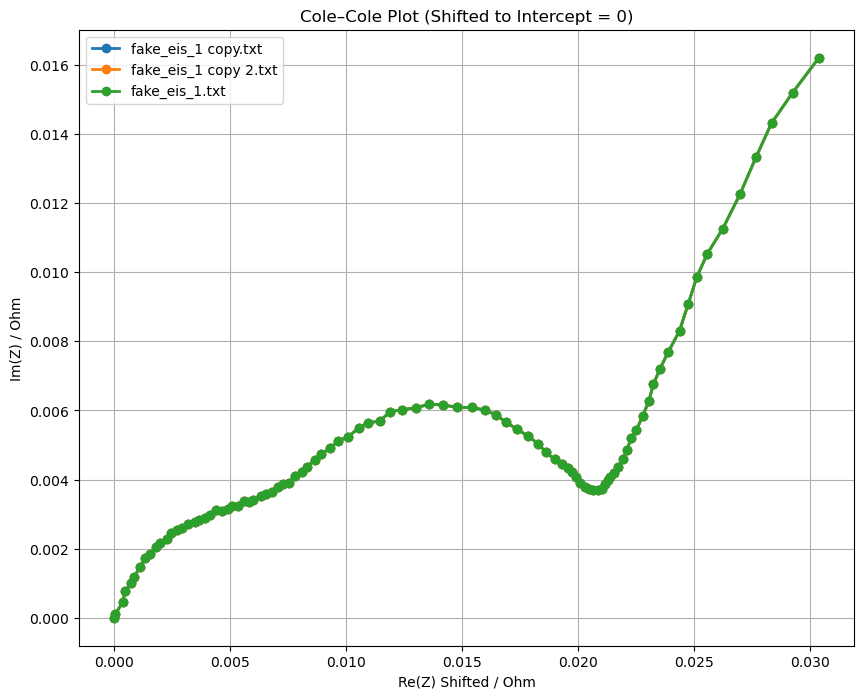

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

directory = './'
files = [f for f in os.listdir(directory) if f.endswith('.txt')]

plt.figure(figsize=(10, 8))

intercepts = []   # 用来存储每个文件的Sample-Intercept表

for file in files:
    data = pd.read_csv(file, sep='\t', skiprows=1,
                       names=['freq/Hz', 'Re(Z)/Ohm', 'Im(Z)/Ohm'])

    # Step 1: 翻转Im
    data['Im(Z)/Ohm'] = -data['Im(Z)/Ohm']

    # ---- Step 2: 使用原始翻转后的数据寻找符号变化区间 ----
    x = data['Re(Z)/Ohm'].values
    y = data['Im(Z)/Ohm'].values

    # 找 y 过0的区间
    sign_change_idx = np.where(np.diff(np.sign(y)) != 0)[0]

    x_intercept = None  # 初始设置

    if len(sign_change_idx) > 0:
        idx = sign_change_idx[0]

        # 插值区间
        x1, x2 = x[idx], x[idx + 1]
        y1, y2 = y[idx], y[idx + 1]

        # ---- Step 3: 线性插值求 Im=0 对应的 Re ----
        x_intercept = x1 - y1 * (x2 - x1) / (y2 - y1)

        # ---- Step 4: 将交点加入 DataFrame ----
        intercept_df = pd.DataFrame({
            'freq/Hz': [np.nan],
            'Re(Z)/Ohm': [x_intercept],
            'Im(Z)/Ohm': [0]
        })
        data = pd.concat([data, intercept_df], ignore_index=True)

    # ---- 记录交点到表格 ----
    intercepts.append({"Sample": file, "Re_intercept": x_intercept})

    # ---- Step 5: 删除所有 Im<0 的点（确保从0开始） ----
    data = data[data['Im(Z)/Ohm'] >= 0]
    data = data.sort_values('Re(Z)/Ohm')

    # ---- Step 6: 所有曲线平移，使交点对齐到 0 ----
    if x_intercept is not None:
        data["Re_shifted"] = data["Re(Z)/Ohm"] - x_intercept
    else:
        data["Re_shifted"] = data["Re(Z)/Ohm"]   # 若无交点，不平移

    # ---- Step 7: 作平移后的图 ----
    plt.plot(
        data['Re_shifted'],
        data['Im(Z)/Ohm'],
        label=file,
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=6
    )

# ---- 打印和输出交点表格 ----
intercept_table = pd.DataFrame(intercepts)
print("\n=== 每个 Sample 的零交点（Re 值） ===")
print(intercept_table)

plt.title('Cole–Cole Plot (Shifted to Intercept = 0)')
plt.xlabel('Re(Z) Shifted / Ohm')
plt.ylabel('Im(Z) / Ohm')
plt.legend()
plt.grid(True)
plt.show()

intercept_table.to_csv("intercepts_summary.csv", index=False)

